# Train a Deep NN to predict Asset Price returns

In practice, we need to explore variations of the design options outlined above because we can rarely be sure from the outset which network architecture best suits the data.

In this section, we will explore various options to build a simple feedforward Neural Network to predict asset price returns for a one-day horizon.

## Imports & Settings

In [1]:
import warnings

from keras.callbacks import TensorBoard
from keras.regularizers import L1L2
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from ast import literal_eval as make_tuple
from time import time
from pathlib import Path
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

In [3]:
train_nn = False
ols = True
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, calculate_splits, reduce_footprint

In [5]:
np.random.seed(42)
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [6]:
results_path = Path('results_5Min_ncut_1obsy_lbackfac_1')
if not results_path.exists():
    results_path.mkdir()
    
checkpoint_path = results_path / 'logs'

## Create a stock return series to predict asset price moves

To develop our trading strategy, we use the daily stock returns for some 995 US stocks for the eight year period from 2010 to 2017, and the features developed in Chapter 12 that include volatility and momentum factors as well as lagged returns with cross-sectional and sectoral rankings.

In [7]:
multiindex_cols = ['date', 'ticker']
data_path = results_path / 'data.ftr'
data = pd.read_feather(data_path).sort_index().set_index(multiindex_cols)
data

rsi   bb_high    bb_low      NATR  \
date                ticker                                              
2013-04-01 04:10:00 btc-usd   37.514507  0.013462  0.007423  0.103548   
2013-04-01 04:15:00 btc-usd   37.514507  0.013316  0.007711  0.096152   
2013-04-01 04:20:00 btc-usd   37.514507  0.013022  0.007985  0.089284   
2013-04-01 04:25:00 btc-usd   37.514507  0.012306  0.008103  0.082906   
2013-04-01 04:30:00 btc-usd   60.570385  0.006993  0.012745  0.111497   
...                                 ...       ...       ...       ...   
2021-06-23 10:30:00 wbtc-usd  45.257854  0.003403  0.001893  0.256668   
                    xtz-usd   53.174335  0.007352  0.010198  0.498391   
2021-06-23 10:35:00 algo-usd  55.360226  0.010465  0.015999  0.609050   
                    chz-usd   56.763741  0.000720  0.012802  0.185714   
                    leo-usd   31.829496  0.103511  0.014611  2.047007   

                                   ATR       PPO      MACD  sector       r01  \
date                ticker                                                     
2013-04-01 04:10:00 btc-usd  -0.420062 -0.444706 -0.010691       0  0.000000   
2013-04-01 04:15:00 btc-usd  -0.420171 -0.407437 -0.010540       0  0.000000   
2013-04-01 04:20:00 btc-usd  -0.420272 -0.370154 -0.010377       0  0.000000   
2013-04-01 04:25:00 btc-usd  -0.420366 -0.332856 -0.010207       0  0.000000   
2013-04-01 04:30:00 btc-usd  -0.419937 -0.273530 -0.009155       0  0.004908   
...                                ...       ...       ...     ...       ...   
2021-06-23 10:30:00 wbtc-usd  0.414292 -0.114801 -0.231939       2  0.002040   
                    xtz-usd   0.312738  0.012224  0.201851       1  0.004034   
2021-06-23 10:35:00 algo-usd  0.343689 -0.395638  0.046638       0  0.001464   
                    chz-usd  -0.014518 -0.123004 -0.181407       2  0.005055   
                    leo-usd   9.837584  0.093304 -6.009774       2 -0.009775   

                                   r02  ...   r01_fwd   r02_fwd   r06_fwd  \
date                ticker              ...                                 
2013-04-01 04:10:00 btc-usd   0.000000  ...  0.000000  0.000000  0.004908   
2013-04-01 04:15:00 btc-usd   0.000000  ...  0.000000  0.000000  0.004908   
2013-04-01 04:20:00 btc-usd   0.000000  ...  0.000000  0.004908  0.004908   
2013-04-01 04:25:00 btc-usd   0.000000  ...  0.004908  0.004908  0.004908   
2013-04-01 04:30:00 btc-usd   0.004908  ...  0.000000  0.000000  0.000000   
...                                ...  ...       ...       ...       ...   
2021-06-23 10:30:00 wbtc-usd  0.002040  ...  0.000000  0.003571  0.006964   
                    xtz-usd   0.003659  ...  0.001265  0.005468  0.024252   
2021-06-23 10:35:00 algo-usd  0.006811  ...  0.005086  0.012129  0.025926   
                    chz-usd   0.005055  ...  0.000000  0.000000  0.009495   
                    leo-usd  -0.016079  ...  0.004479  0.011987  0.033596   

                               r12_fwd   r24_fwd   r48_fwd  year  month  \
date                ticker                                                
2013-04-01 04:10:00 btc-usd   0.004908  0.011488  0.009169  2013      4   
2013-04-01 04:15:00 btc-usd   0.010787  0.011488  0.009169  2013      4   
2013-04-01 04:20:00 btc-usd   0.010787  0.011488  0.009169  2013      4   
2013-04-01 04:25:00 btc-usd   0.011488  0.014752  0.009169  2013      4   
2013-04-01 04:30:00 btc-usd   0.006548  0.009796  0.004240  2013      4   
...                                ...       ...       ...   ...    ...   
2021-06-23 10:30:00 wbtc-usd -0.000354  0.006138  0.003807  2021      6   
                    xtz-usd   0.011605  0.008072 -0.000707  2021      6   
2021-06-23 10:35:00 algo-usd  0.010619  0.030324  0.032619  2021      6   
                    chz-usd  -0.013197 -0.013197 -0.025187  2021      6   
                    leo-usd   0.074782  0.018499  0.031730  2021      6   

                              weekday  hour  
date                t

In [8]:
group_levels = ['ticker']
data.groupby(group_levels).count()

,rsi,bb_high,bb_low,NATR,ATR,PPO,MACD,sector,r01,r02,...,r01_fwd,r02_fwd,r06_fwd,r12_fwd,r24_fwd,r48_fwd,year,month,weekday,hour
ticker,,,,,,,,,,,,,,,,,,,,,
algo-usd,211069,211069,211069,211069,211069,211069,211069,211069,211069,211069,...,211069,211069,211069,211069,211069,211069,211069,211069,211069,211069
amp-usd,209323,209323,209323,209323,209323,209323,209323,209323,209323,209323,...,209323,209323,209323,209323,209323,209323,209323,209323,209323,209323
atom-usd,227442,227442,227442,227442,227442,227442,227442,227442,227442,227442,...,227442,227442,227442,227442,227442,227442,227442,227442,227442,227442
bat-usd,363266,363266,363266,363266,363266,363266,363266,363266,363266,363266,...,363266,363266,363266,363266,363266,363266,363266,363266,363266,363266
bnt-usd,302099,302099,302099,302099,302099,302099,302099,302099,302099,302099,...,302099,302099,302099,302099,302099,302099,302099,302099,302099,302099
bsv-usd,269331,269331,269331,269331,269331,269331,269331,269331,269331,269331,...,269331,269331,269331,269331,269331,269331,269331,269331,269331,269331
btc-usd,865511,865511,865511,865511,865511,865511,865511,865511,865511,865511,...,865511,865511,865511,865511,865511,865511,865511,865511,865511,865511
btg-usd,383934,383934,383934,383934,383934,383934,383934,383934,383934,383934,...,383934,383934,383934,383934,383934,383934,383934,383934,383934,383934
btt-usd,246176,246176,246176,246176,246176,246176,246176,246176,246176,246176,...,246176,246176,246176,246176,246176,246176,246176,246176,246176,246176


In [9]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11623852 entries, (Timestamp('2013-04-01 04:10:00'), 'btc-usd') to (Timestamp('2021-06-23 10:35:00'), 'leo-usd')
Data columns (total 36 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   rsi          11623852 non-null  float32
 1   bb_high      11623852 non-null  float32
 2   bb_low       11623852 non-null  float32
 3   NATR         11623852 non-null  float32
 4   ATR          11623852 non-null  float32
 5   PPO          11623852 non-null  float32
 6   MACD         11623852 non-null  float32
 7   sector       11623852 non-null  int16  
 8   r01          11623852 non-null  float32
 9   r02          11623852 non-null  float32
 10  r06          11623852 non-null  float32
 11  r12          11623852 non-null  float32
 12  r24          11623852 non-null  float32
 13  r48          11623852 non-null  float32
 14  r01dec       11623852 non-null  float32
 15  r02dec       11623852 non-null  fl

In [10]:
dates= data.index.get_level_values('date')
dates.min(), dates.max()

(Timestamp('2013-04-01 04:10:00'), Timestamp('2021-06-23 10:35:00'))

In [11]:
outcomes = data.filter(like='fwd').columns.tolist()
outcomes

['r01_fwd', 'r02_fwd', 'r06_fwd', 'r12_fwd', 'r24_fwd', 'r48_fwd']

In [12]:
lookaheads = []
for outcome in outcomes:
    lookaheads.append(int(outcome.replace('r', '').replace('_fwd', '')))

#lookaheadss = [int(outcome.replace('r', '').replace('r', '')) for outcome in outcomes]
#print(lookaheadss)
print(lookaheads)
# plus one just to make sure it always has enough distance to not have data leakage
lookahead = np.max(lookaheads)+1
lookahead

[1, 2, 6, 12, 24, 48]


49

In [13]:
data = data.swaplevel().sort_index()

In [14]:
X_cv = data.drop(outcomes, axis=1)
y_cv = data[outcomes]
X_cv.shape, y_cv.shape
#X_cv = data.loc[idx[:, :'2021-3'], :].drop(outcomes, axis=1)
#y_cv = data.loc[idx[:, :'2021-3'], outcome]
#X_cv = data.loc[idx[:, :], :].drop(outcomes, axis=1)
#y_cv = data.loc[idx[:, :], outcome]

((11623852, 30), (11623852, 6))

In [15]:
y_cv.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11623852 entries, ('algo-usd', Timestamp('2019-06-21 13:35:00')) to ('zec-usd', Timestamp('2021-06-23 10:15:00'))
Data columns (total 6 columns):
 #   Column   Non-Null Count     Dtype  
---  ------   --------------     -----  
 0   r01_fwd  11623852 non-null  float32
 1   r02_fwd  11623852 non-null  float32
 2   r06_fwd  11623852 non-null  float32
 3   r12_fwd  11623852 non-null  float32
 4   r24_fwd  11623852 non-null  float32
 5   r48_fwd  11623852 non-null  float32
dtypes: float32(6)
memory usage: 371.4 MB


In [16]:
len(X_cv.index.get_level_values('ticker').unique())

32

In [17]:
X_cv.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11623852 entries, ('algo-usd', Timestamp('2019-06-21 13:35:00')) to ('zec-usd', Timestamp('2021-06-23 10:15:00'))
Data columns (total 30 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   rsi          11623852 non-null  float32
 1   bb_high      11623852 non-null  float32
 2   bb_low       11623852 non-null  float32
 3   NATR         11623852 non-null  float32
 4   ATR          11623852 non-null  float32
 5   PPO          11623852 non-null  float32
 6   MACD         11623852 non-null  float32
 7   sector       11623852 non-null  int16  
 8   r01          11623852 non-null  float32
 9   r02          11623852 non-null  float32
 10  r06          11623852 non-null  float32
 11  r12          11623852 non-null  float32
 12  r24          11623852 non-null  float32
 13  r48          11623852 non-null  float32
 14  r01dec       11623852 non-null  float32
 15  r02dec       11623852 non-null  f

## Automate model generation

The following `make_model` function illustrates how to flexibly define various architectural elements for the search process. The dense_layers argument defines both the depth and width of the network as a list of integers. We also use dropout for regularization, expressed as a float in the range [0, 1] to define the probability that a given unit will be excluded from a training iteration.

In [18]:
def make_model(dense_layers, activation, dropout, reg_L1, reg_L2):
    '''Creates a multi-layer perceptron model

    dense_layers: List of layer sizes; one number per layer
    '''

    model = Sequential()
    for i, layer_size in enumerate(dense_layers, 1):
        if i == 1:
            model.add(Dense(layer_size, input_dim=X_cv.shape[1],
                            activity_regularizer=L1L2(reg_L1, reg_L2)))
        else:
            model.add(Dense(layer_size,
                            activity_regularizer=L1L2(reg_L1, reg_L2)))
        model.add(Activation(activation))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='Adam')

    return model

## Cross-validate multiple configurations with TensorFlow

### Train-Test Split

We split the data into a training set for cross-validation, and keep the last 12 months with data as holdout test:

In [19]:
n_datetimes = X_cv.unstack(group_levels).index.nunique()
n_datetimes_y = y_cv.unstack(group_levels).index.nunique()
assert n_datetimes == n_datetimes_y

In [20]:
n_splits = int(3.5*6-2)
train_test_ratio = 6

n_splits = 12
train_test_ratio = 12

train_period_length, test_period_length = calculate_splits(X_cv, lookahead=lookahead,
                                                           train_test_ratio=train_test_ratio,
                                                           n_splits=n_splits,
                                                           unstack=group_levels)

train_period_length, test_period_length

unstack ['ticker']
Duplicate index: 


(432170, 36014)

In [21]:
train_period_length/8**4

105.51025390625

In [22]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)


### Define CV Parameters

Now we just need to define our Keras classifier using the make_model function, set cross-validation (see chapter 6 on The Machine Learning Process and following for the OneStepTimeSeriesSplit), and the parameters that we would like to explore. 

We pick several one- and two-layer configurations, relu and tanh activation functions, and different dropout rates. We could also try out different optimizers (but did not run this experiment to limit what is already a computationally intensive effort):


In [ ]:
"""
dense_layer_opts = [(32, 16), (32, 32),
                    (64, 64), (128, 64),
                    (128, 128), (128, 64),
                    (256, 256), (256, 128)]
activation_opts = ['tanh', 'relu']
dropout_opts = [0.25, 0.5, 0.75]
"""

dense_layer_opts = [(126, 64),
                    (64, 32),]
activation_opts = ['relu']
dropout_opts = [0.5]
reg_L1_opts = [0]
reg_L2_opts = [0]
outcome_opts = outcomes[2:]
outcome_opts
# train for a subset of all forward returns
# outcomes = outcomes[:1]

In [24]:
param_grid = list(product(dense_layer_opts, activation_opts, dropout_opts,
                          reg_L1_opts, reg_L2_opts, outcome_opts))

np.random.shuffle(param_grid)

In [25]:
len(param_grid)

8

In [26]:
params = ['dense_layers', 'dropout', 'batch_size', 'activation',
          'reg_L1', 'reg_L2', 'outcome']

To trigger the parameter search, we instantiate a GridSearchCV object, define the fit_params that will be passed to the Keras model’s fit method, and provide the training data to the GridSearchCV fit method:

In [27]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    return x_train, y_train, x_val, y_val

print('x_cv dates {}:{}'.format(X_cv.index.get_level_values('date').min(),
                                 X_cv.index.get_level_values('date').max()))
dates = []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X_cv)):
    x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, X_cv, train_idx, test_idx)
    date = {}
    date['train_date_min'] = x_train.index.get_level_values('date').min()
    date['train_date_max'] = x_train.index.get_level_values('date').max()
    date['val_date_min'] = x_val.index.get_level_values('date').min()
    date['val_date_max'] = x_val.index.get_level_values('date').max()
    date['train_idx'] = train_idx
    date['test_idx'] = test_idx
    dates.append(date)

    print("train dates {} to {}".format(date['train_date_min'],
                                     date['train_date_max']))

    print("val dates   {} {}".format(date['val_date_min'],
                                     date['val_date_max']))

    print("t duration {}".format(date['train_date_max']-date['train_date_min'] ))
    print("vduration {}".format(date['val_date_max']-date['val_date_min'] ))



x_cv dates 2013-04-01 04:10:00:2021-06-23 10:35:00
train dates 2017-01-09 11:20:00 to 2021-02-18 05:25:00
val dates   2021-02-18 09:30:00 2021-06-23 10:35:00
t duration 1500 days 18:05:00
vduration 125 days 01:05:00
train dates 2016-09-06 10:10:00 to 2020-10-16 04:15:00
val dates   2020-10-16 08:20:00 2021-02-18 09:25:00
t duration 1500 days 18:05:00
vduration 125 days 01:05:00
train dates 2016-05-04 09:00:00 to 2020-06-13 03:05:00
val dates   2020-06-13 07:10:00 2020-10-16 08:15:00
t duration 1500 days 18:05:00
vduration 125 days 01:05:00
train dates 2015-12-31 07:50:00 to 2020-02-09 01:55:00
val dates   2020-02-09 06:00:00 2020-06-13 07:05:00
t duration 1500 days 18:05:00
vduration 125 days 01:05:00
train dates 2015-08-28 06:40:00 to 2019-10-07 00:45:00
val dates   2019-10-07 04:50:00 2020-02-09 05:55:00
t duration 1500 days 18:05:00
vduration 125 days 01:05:00
train dates 2015-04-25 05:30:00 to 2019-06-03 23:35:00
val dates   2019-06-04 03:40:00 2019-10-07 04:45:00
t duration 1500 d

In [28]:
X_cv.shape[0]

11623852

In [29]:
early_stop = False

if train_nn:
    tb_callback = TensorBoard(log_dir=results_path / 'tensorboard',
                              histogram_freq=1,
                              write_graph=True,
                              write_images=True)
    ic_file = results_path / 'val_scores.h5'

    ic = []

    scaler = StandardScaler()

    for params in tqdm(param_grid):
        dense_layers, activation, dropout, reg_L1, reg_L2, outcome = params
        for batch_size in [4096*2]:
            print(dense_layers, activation, dropout, batch_size, reg_L1, reg_L2, outcome)
            checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(dropout) / str(batch_size) / str(reg_L1) / str(reg_L2) / str(outcome)
            if not checkpoint_dir.exists():
                checkpoint_dir.mkdir(parents=True, exist_ok=True)
            start = time()

            for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
                # get train & validation data

                # lookahead according to parameter
                y_cv_outcome = y_cv[outcome]
                x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv_outcome, train_idx, test_idx)

                # scale features
                x_train = scaler.fit_transform(x_train)
                x_val = scaler.transform(x_val)

                # set up dataframes to log results
                preds = y_val.to_frame('actual')
                r = pd.DataFrame(index=y_val.groupby(level='date').size().index)

                # create model based on validation parameters
                # TODO make a more elaborate way to count len(y)
                model = make_model(dense_layers, activation, dropout,
                                   reg_L1, reg_L2)
                best_ic = -np.inf
                stop = 0

                # cross-validate for x epochs
                for epoch in range(15):

                    model.fit(x_train,
                              y_train,
                              batch_size=batch_size,
                              epochs=1,
                              verbose=0,
                              shuffle=True,
                              validation_data=(x_val, y_val)
                              )

                    model.save_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
                    preds[epoch] = model.predict(x_val).squeeze()
                    r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
                    # print("fold {}".format(fold))
                    ic_approx = float(r[epoch].mean()) + float(r[epoch].median())
                    if ic_approx > best_ic:
                        best_ic = ic_approx*0.95
                        stop = 0
                    else:
                        stop += 1
                    print(f'fold:{fold + 1:02d} | ep:{epoch + 1:03d} | mean_r{r[epoch].mean():7.4f} | med_r{r[epoch].median():7.4f} | stop {stop}')
                    if stop == 3 and early_stop:
                        break
                print("time: {}".format(time()-start))
                ic.append(r.assign(dense_layers=str(dense_layers),
                                   activation=activation,
                                   dropout=dropout,
                                   batch_size=batch_size,
                                   reg_L1=reg_L1,
                                   reg_L2=reg_L2,
                                   fold=fold,
                                   outcome=outcome))

            t = time()-start
            pd.concat(ic).to_hdf(ic_file, 'ic_by_day')




### Evaluate predictive performance



In [30]:
ic = pd.read_hdf(results_path / 'val_scores.h5', 'ic_by_day')
ic = reduce_footprint(ic)

ic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3457344 entries, 2021-02-18 09:30:00 to 2017-09-16 21:45:00
Data columns (total 23 columns):
 #   Column        Dtype   
---  ------        -----   
 0   0             float32 
 1   1             float32 
 2   2             float32 
 3   3             float32 
 4   4             float32 
 5   5             float32 
 6   6             float32 
 7   7             float32 
 8   8             float32 
 9   9             float32 
 10  10            float32 
 11  11            float32 
 12  12            float32 
 13  13            float32 
 14  14            float32 
 15  dense_layers  category
 16  activation    category
 17  dropout       float32 
 18  batch_size    int16   
 19  reg_L1        int16   
 20  reg_L2        int16   
 21  fold          int16   
 22  outcome       category
dtypes: category(3), float32(16), int16(4)
memory usage: 273.7 MB


In [31]:
ic.groupby(params).size()

dense_layers  dropout  batch_size  activation  reg_L1  reg_L2  outcome
(126, 64)     0.5      8192        relu        0       0       r06_fwd    432168
                                                               r12_fwd    432168
                                                               r24_fwd    432168
                                                               r48_fwd    432168
(64, 32)      0.5      8192        relu        0       0       r06_fwd    432168
                                                               r12_fwd    432168
                                                               r24_fwd    432168
                                                               r48_fwd    432168
dtype: int64

In [32]:
ic_long = pd.melt(ic, id_vars=params + ['fold'], var_name='epoch', value_name='ic')
ic_long = reduce_footprint(ic_long)
ic_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51860160 entries, 0 to 51860159
Data columns (total 10 columns):
 #   Column        Dtype   
---  ------        -----   
 0   dense_layers  category
 1   dropout       float32 
 2   batch_size    int16   
 3   activation    category
 4   reg_L1        int16   
 5   reg_L2        int16   
 6   outcome       category
 7   fold          int16   
 8   epoch         category
 9   ic            float32 
dtypes: category(4), float32(2), int16(4)
memory usage: 989.2 MB


In [33]:
#ic_long = ic_long.groupby(params+ ['epoch']).ic.mean().to_frame('ic').reset_index()
ic_long = ic_long.groupby(params+ ['epoch', 'fold']).ic.mean().to_frame('ic').reset_index()


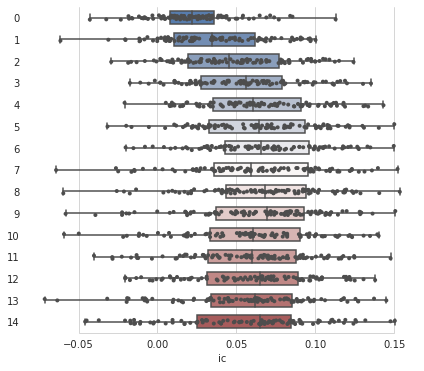

In [34]:
f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="ic", y="epoch", data=ic_long,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="ic", y="epoch", data=ic_long,
              size=4, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
f.savefig(results_path / 'ic_boxplot_epoch.svg', dpi=300)


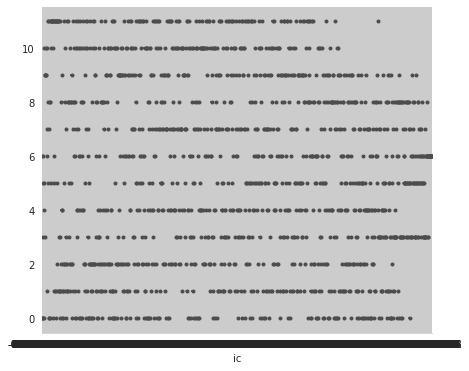

In [35]:
f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="ic", y="fold", data=ic_long,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="ic", y="fold", data=ic_long,
              size=4, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
f.savefig(results_path / 'ic_boxplot_fold.svg', dpi=300)


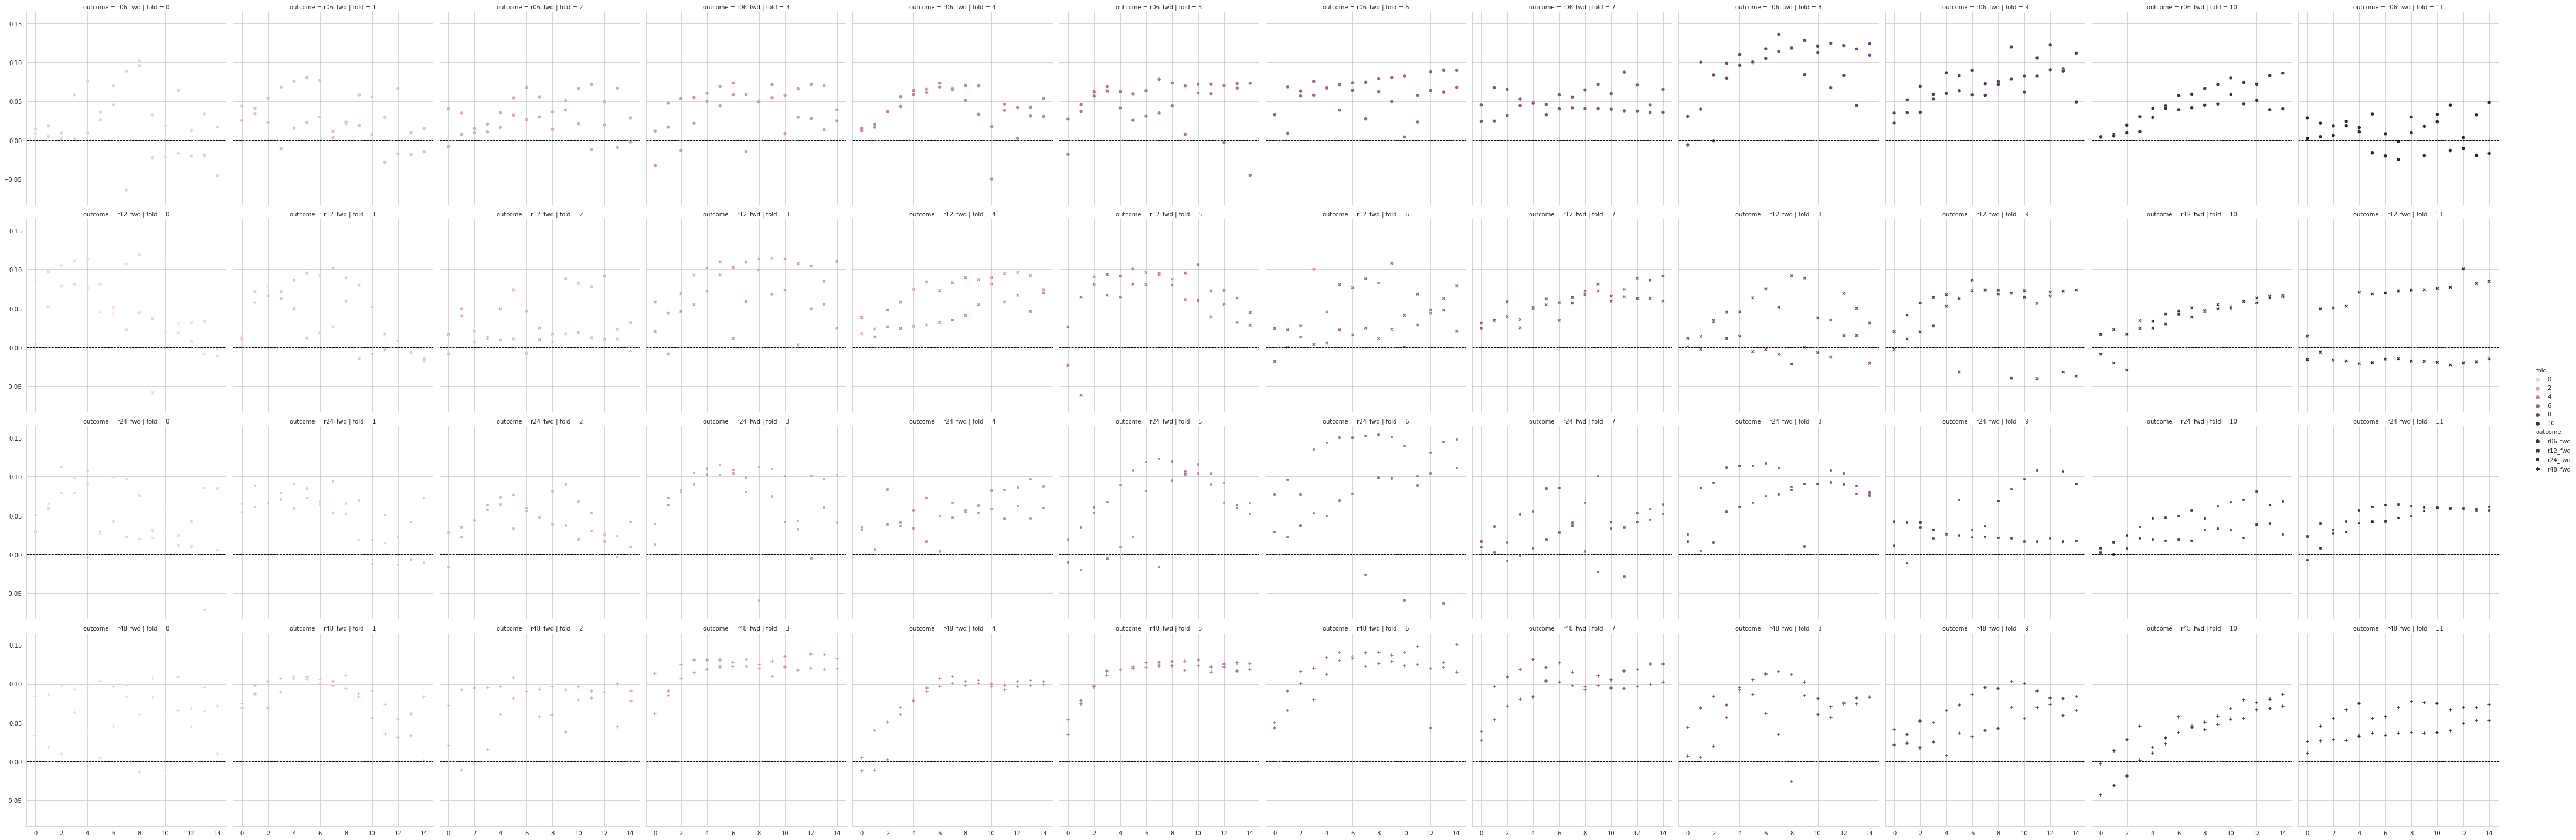

In [36]:
g = sns.relplot(x='epoch', y='ic', col='fold', row='outcome',
                hue='fold', style='outcome',
                #data=ic_long[ic_long.dropout>0], kind='line')
                data=ic_long, kind='scatter', legend=True)
g.map(plt.axhline, y=0, ls='--', c='k', lw=1)
g.savefig(results_path / 'ic_lineplot_fold_outcome.svg', dpi=300)

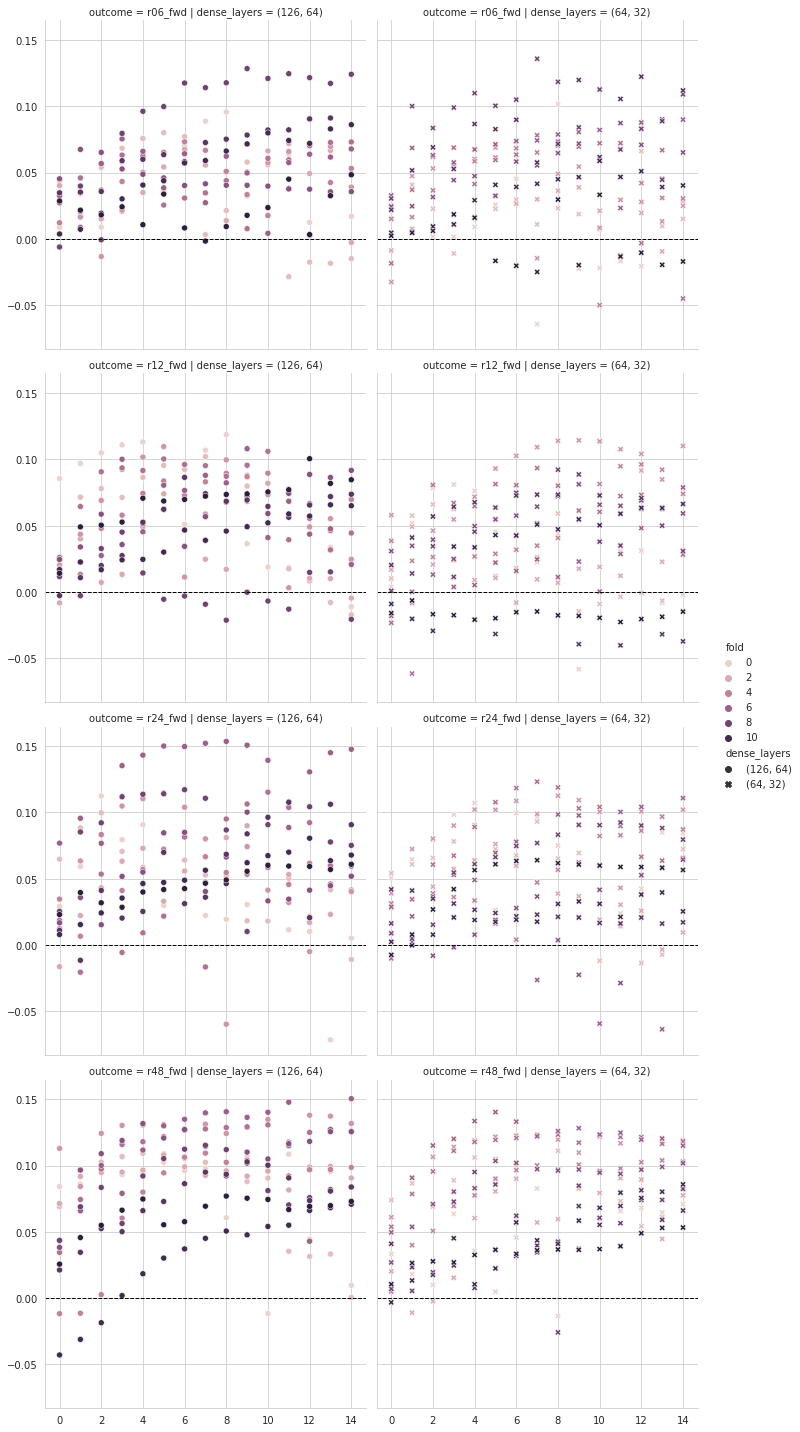

In [48]:
g = sns.relplot(x='epoch', y='ic', row='outcome', col='dense_layers',
                hue='fold', style='dense_layers',
                #data=ic_long[ic_long.dropout>0], kind='line')
                data=ic_long, kind='scatter', legend=True)
g.map(plt.axhline, y=0, ls='--', c='k', lw=1)
g.savefig(results_path / 'ic_lineplot_dense_layers_outcome.svg', dpi=300)




In [39]:
if ols:
    print("1")
    def run_ols(ic):
        ic.dense_layers = ic.dense_layers.str.replace(', ', '-').str.replace('(', '').str.replace(')', '')
        data = pd.melt(ic, id_vars=params, var_name='epoch', value_name='ic')
        data.epoch = data.epoch.astype(int).astype(str).apply(lambda x: f'{int(x):02.0f}')
        model_data = pd.get_dummies(data.sort_values(params + ['epoch']), columns=['epoch'] + params, drop_first=True).sort_index(1)
        model_data.columns = [s.split('_')[-1] for s in model_data.columns]
        model = sm.OLS(endog=model_data.ic, exog=sm.add_constant(model_data.drop('ic', axis=1)), missing='drop')
        return model.fit()

    model = run_ols(ic.drop('fold', axis=1))

    print(model.summary())

1
                            OLS Regression Results                            
Dep. Variable:                     ic   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                 1.550e+04
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        09:16:16   Log-Likelihood:            -3.8683e+06
No. Observations:            47124348   AIC:                         7.737e+06
Df Residuals:                47124329   BIC:                         7.737e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.000    116.993      0

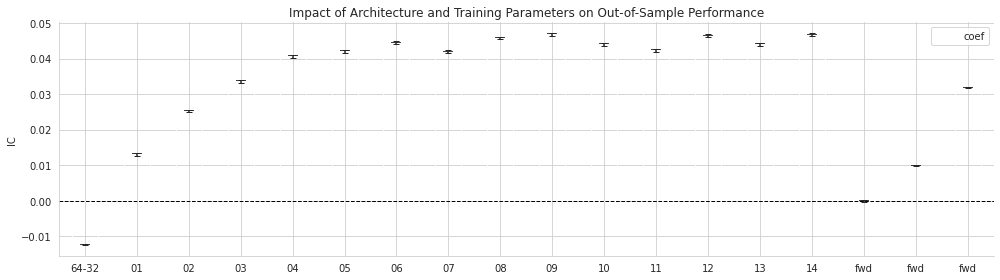

In [40]:
if ols:
    fig, ax = plt.subplots(figsize=(14, 4))

    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date') & (coefs.variable != 'const')]

    coefs.plot(x='variable', y='coef', kind='bar',
               ax=ax, color='none', capsize=3,
               yerr='error', legend=True, rot=0, title='Impact of Architecture and Training Parameters on Out-of-Sample Performance')
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')
    """
    ax.annotate('Batch Size', xy=(.02, -0.1), xytext=(.02, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=1.3, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Layers', xy=(.1, -0.1), xytext=(.1, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=4.8, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Dropout', xy=(.2, -0.1), xytext=(.2, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.8, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Epochs', xy=(.62, -0.1), xytext=(.62, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=30.5, lengthB=1.0', lw=1.0, color='black'))
    """
    sns.despine()
    fig.tight_layout()
    fig.savefig(results_path / 'ols_coef', dpi=300)

## Make Predictions



In [41]:

def generate_predictions(dense_layers, activation, dropout, batch_size, reg_L1, reg_L2, outcome, epoch):
    # data = pd.read_hdf(data_path, 'model_data').dropna().sort_index()
    # outcomes = data.filter(like='fwd').columns.tolist()
    # X_cv = data.loc[idx[:, :'2021-05'], :].drop(outcomes, axis=1)
    # X_cv = data.drop(outcomes, axis=1)
    # input_dim = X_cv.shape[1]
    # y_cv = data.loc[idx[:, :'2017'], 'r01_fwd']

    scaler = StandardScaler()
    predictions = []
    
    do = '0' if str(dropout) == '0.0' else str(dropout)

    checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(do) / str(batch_size) / str(reg_L1) / str(reg_L2) / str(outcome)
        
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
        x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv[outcome], train_idx, test_idx)
        x_val = scaler.fit(x_train).transform(x_val)
        """
        print("split {} {}".format(y_val.index.get_level_values('date').min(),
                                   y_val.index.get_level_values('date').max()))
        print("split {} {}".format(dates[fold]['val_date_min'],
                                   dates[fold]['val_date_max']))
        """
        model = make_model(make_tuple(dense_layers), activation, dropout, reg_L1, reg_L2)
        status = model.load_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(x_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)        

In [42]:
print(params)

['dense_layers', 'dropout', 'batch_size', 'activation', 'reg_L1', 'reg_L2', 'outcome']


In [43]:
def get_best_params(n=5, ic_given=None):
    """Get the best parameters across all folds by daily median IC"""
    params = ['dense_layers', 'activation', 'dropout', 'batch_size',
              'reg_L1', 'reg_L2', 'outcome']
    if ic_given==None:
        ic = pd.read_hdf(results_path / 'val_scores.h5', 'ic_by_day').drop('fold', axis=1)
    else:
        ic = ic_given
    dates = sorted(ic.index.unique())
    # train_period = 12 * 30 * 24
    train_dates = dates# [:train_period]
    ic = ic.loc[train_dates]
    return (ic.groupby(params)
            .median()
            .stack()
            .to_frame('ic')
            .reset_index()
            .rename(columns={'level_7': 'epoch'})
            .nlargest(n=n, columns='ic')
            .drop('ic', axis=1)
            .to_dict('records'))


In [44]:
best_params = get_best_params()
for param in best_params:
    print(param)
predictions = []
for i, params in tqdm(enumerate(best_params)):
    predictions.append(generate_predictions(**params).to_frame(f'#{i:2}'))

predictions = pd.concat(predictions, axis=1)
predictions.sort_index(inplace=True)
print(predictions.info())

0it [00:00, ?it/s]

{'dense_layers': '(126, 64)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'outcome': 'r48_fwd', 'epoch': 14}
{'dense_layers': '(126, 64)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'outcome': 'r48_fwd', 'epoch': 7}
{'dense_layers': '(126, 64)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'outcome': 'r48_fwd', 'epoch': 9}
{'dense_layers': '(126, 64)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'outcome': 'r48_fwd', 'epoch': 6}
{'dense_layers': '(126, 64)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'outcome': 'r48_fwd', 'epoch': 13}


5it [07:23, 88.77s/it]


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10437952 entries, ('algo-usd', Timestamp('2019-06-21 13:35:00')) to ('zec-usd', Timestamp('2021-06-23 10:15:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   # 0     float32
 1   # 1     float32
 2   # 2     float32
 3   # 3     float32
 4   # 4     float32
dtypes: float32(5)
memory usage: 278.2 MB
None


In [45]:
predictions.reset_index().to_feather(results_path / 'test_preds.ftr')


In [49]:
# todo select best outcome for y_cv
# todo automatize this selection
targets = y_cv['r48_fwd'].to_frame('target')
targets.sort_index()
results = predictions.join(targets)
results.reset_index().to_feather(results_path / 'results.ftr')

In [50]:
results.groupby('date').count()


,# 0,# 1,# 2,# 3,# 4,target
date,,,,,,
2017-05-14 20:40:00,7,7,7,7,7,7
2017-05-14 20:45:00,7,7,7,7,7,7
2017-05-14 20:50:00,7,7,7,7,7,7
2017-05-14 20:55:00,7,7,7,7,7,7
2017-05-14 21:00:00,7,7,7,7,7,7
...,...,...,...,...,...,...
2021-06-23 10:15:00,25,25,25,25,25,25
2021-06-23 10:20:00,20,20,20,20,20,20
2021-06-23 10:25:00,12,12,12,12,12,12


In [51]:
"""
for i, params in tqdm(enumerate(best_params)):
    results[f'ic #{i:2}'] = results.apply(lambda x: spearmanr(x['target'], x[f'#{i:2}'])[0], axis=1)

results
"""

"\nfor i, params in tqdm(enumerate(best_params)):\n    results[f'ic #{i:2}'] = results.apply(lambda x: spearmanr(x['target'], x[f'#{i:2}'])[0], axis=1)\n\nresults\n"

In [52]:
#results.reset_index().to_feather(results_path / 'results_IC.ftr')



### How to further improve the results

The relatively simple architecture yields some promising results. To further improve performance, you can
- First and foremost, add new features and more data to the model
- Expand the set of architectures to explore, including more or wider layers
- Inspect the training progress and train for more epochs if the validation error continued to improve at 50 epochs

Finally, you can use more sophisticated architectures, including Recurrent Neural Networks (RNN) and Convolutional Neural Networks that are well suited to sequential data, whereas vanilla feedforward NNs are not designed to capture the ordered nature of the features.
